### How do we choose k=16 components to be our fiducial model? The answer is complicated. Here, we show the unsupervised portion of the answer - that the F1 score and AUPRC metrics really do point to k=15-20, and by some measures, they point to k=16 specifically 



In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('/Users/amuratov/gits/EncodeNMF')


In [3]:
NC_ar = [4,8,10,11,12,13,14,15,16,17,18,19,20,24,28,32,36]

In [4]:
NC_ar = np.array(NC_ar)

In [5]:
import OONMF 
import OONMFhelpers as OH

# First we try to find the optimal decision boundary for F1 score analysis

<Figure size 432x288 with 0 Axes>

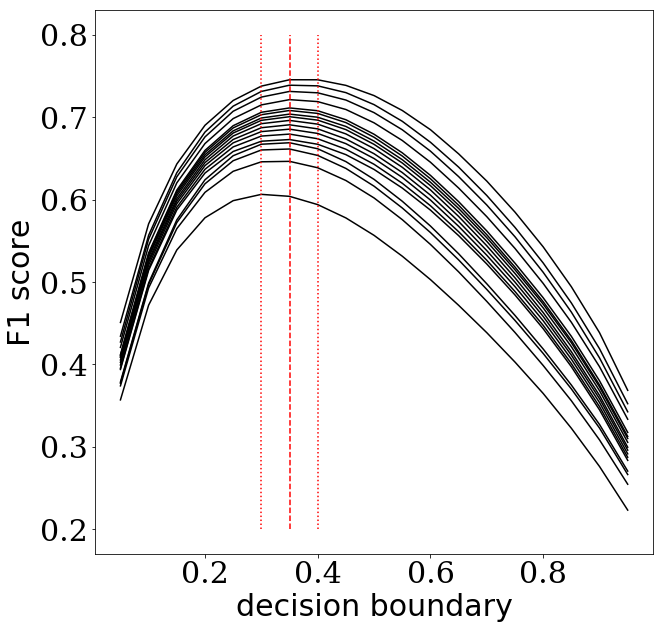

In [6]:
plt.clf()
plt.figure(figsize=(10,10))
prAUC_ar = []
for comp in NC_ar:
    finname = '2018-06-08NC'+str(comp)+'_NNDSVD_TotalPR.txt'
    DF = pd.read_table(finname)
    prec = DF.TP.values / (DF.TP.values + DF.FP.values)
    recall = DF.TP.values / (DF.TP.values + DF.FN.values)
    F1 = 2*prec*recall / (prec+recall)
    prAUC_ar.append(np.trapz([1] + list(recall) + [0], [0] + list(prec) +[1]))
    plt.plot(DF.threshold.values, F1, '-k')

    
plt.plot([0.35, 0.35], [0.2, 0.8], '--r')
plt.plot([0.4, 0.4], [0.2, 0.8], ':r')
plt.plot([0.3, 0.3], [0.2, 0.8], ':r')
OH.increase_axis_fontsize()
plt.xlabel('decision boundary', fontsize=30)
plt.ylabel('F1 score', fontsize=30)

plt.savefig('22219_PRcurve_montage.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()


# pretty clear that 0.35 is an ideal decision boundary for most choices of k


# Now lets look at AUPRC vs k
## and the first derivative of AUPRC

<Figure size 432x288 with 0 Axes>

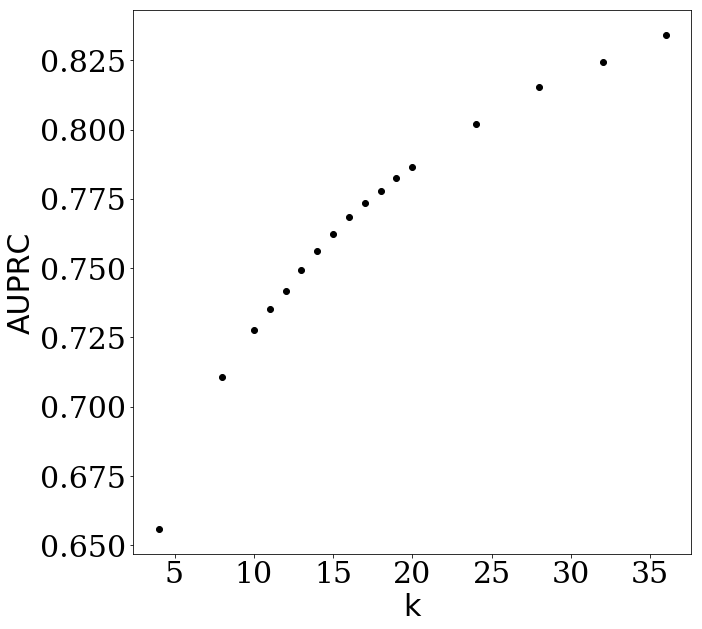

In [7]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, prAUC_ar, 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel('AUPRC', fontsize=30)
#plt.ylim([0,1])
plt.savefig('22219_AUPRC.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

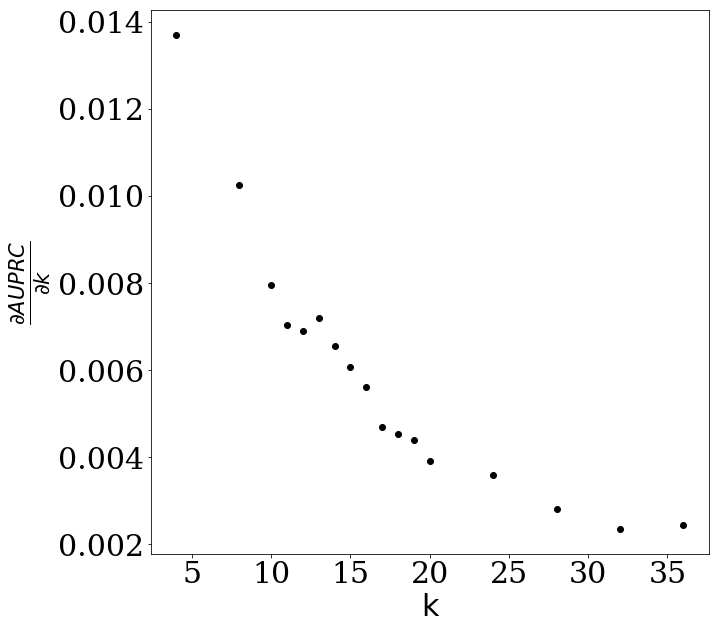

In [8]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, np.gradient(prAUC_ar, NC_ar), 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel(r'$\frac{\partial AUPRC}{\partial k}$', fontsize=30)
plt.savefig('22219_gradient_AUPRC.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

### pretty clear that the first derivative flattens out somewhere between 16 and 20. Butwhere exactly does it happen

Lets see the same thing for F1

In [9]:
F1_ar733 = []
for comp in NC_ar:
    finname = '2018-06-08NC'+str(comp)+'_NNDSVD_TotalPR.txt'
    DF = pd.read_table(finname)
    prec = DF.TP.values / (DF.TP.values + DF.FP.values)
    recall = DF.TP.values / (DF.TP.values + DF.FN.values)
    F1 = 2*prec*recall / (prec+recall)
    #plt.plot(DF.threshold.values, F1, '--b')
    F1_ar733.append(F1[6])


In [10]:
F1_ar733 = np.array(F1_ar733)

<Figure size 432x288 with 0 Axes>

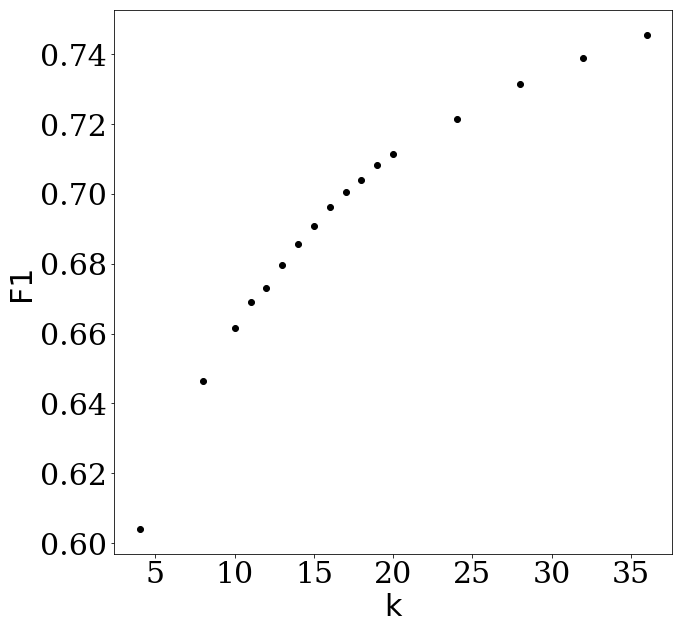

In [34]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, F1_ar733, 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel('F1', fontsize=30)
#plt.ylim([0,1])
plt.savefig('22219_F1.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

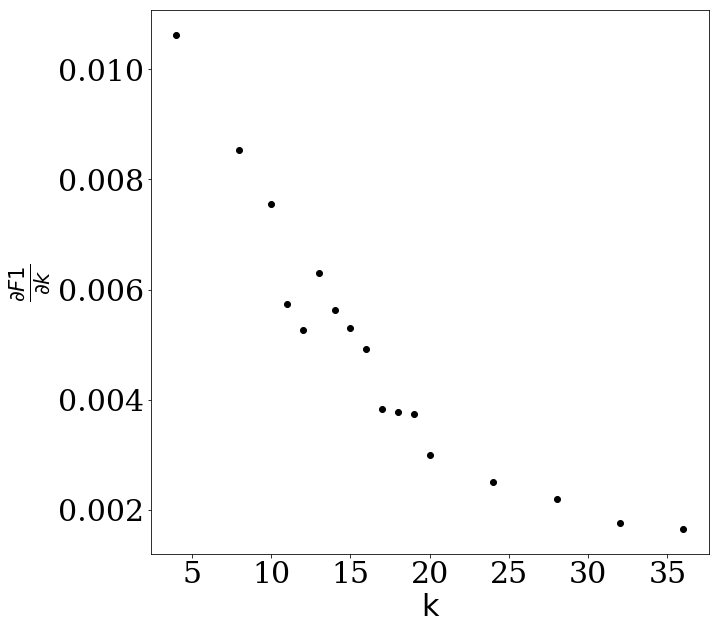

In [37]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot(NC_ar, np.gradient(F1_ar733, NC_ar), 'ok')
OH.increase_axis_fontsize()
plt.xlabel('k', fontsize=30)
plt.ylabel(r'$\frac{\partial F1}{\partial k}$', fontsize=30)
plt.savefig('22219_gradient_F1.pdf', bbox_inches='tight', Transparent=True)
plt.show()
plt.close()

## F1 shows the same sstory. Now we can try to apply an "elbow" method to figure out where we start hitting diminishing reutnrs for increasking k 

### first, lets search all iterations 

In [12]:
from scipy.stats import linregress

In [13]:
cut = (NC_ar>=10) * (NC_ar<=20)

In [14]:
myslope = linregress(NC_ar[cut], F1_ar733[cut])[0]
myintercept = linregress(NC_ar[cut], F1_ar733[cut])[1]
x_fit = np.arange(9,22)
y_fit = x_fit*myslope + myintercept

In [15]:
fitcut = (x_fit>=10) * (x_fit<=20)

<Figure size 432x288 with 0 Axes>

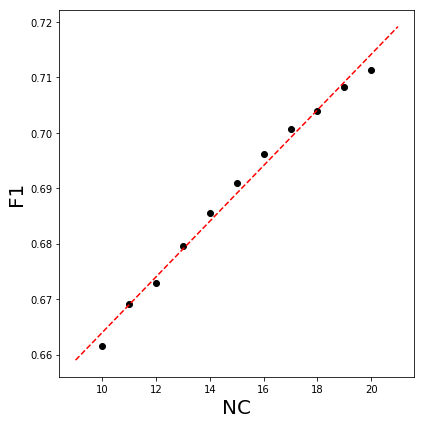

In [16]:
plt.clf()
plt.figure(figsize=(6,6))
plt.plot(NC_ar[cut], F1_ar733[cut], 'ok')
plt.plot(x_fit, y_fit, '--r')
plt.xlabel('NC', fontsize=20)
plt.ylabel('F1', fontsize=20)
plt.tight_layout()

plt.show()

In [17]:
best_NC = 0
best_residual = -9999
for i in range(len(cut[cut])):
    residual =  F1_ar733[cut][i] - y_fit[fitcut][i]
    print(NC_ar[cut][i], F1_ar733[cut][i] - y_fit[fitcut][i])
    if residual > best_residual:
        best_residual = residual
        best_NC = NC_ar[cut][i]


10 -0.0025246649109650354
11 4.6174366738149786e-05
12 -0.0010739541466010527
13 0.0005395276960800111
14 0.001504165866090923
15 0.0017774798559819782
16 0.00209780319346331
17 0.0015897461430128823
18 -0.0002670243912631376
19 -0.0008927777875692433
20 -0.0027964758849694515


In [18]:
best_NC

16

In [19]:
best_residual

0.00209780319346331

<Figure size 432x288 with 0 Axes>

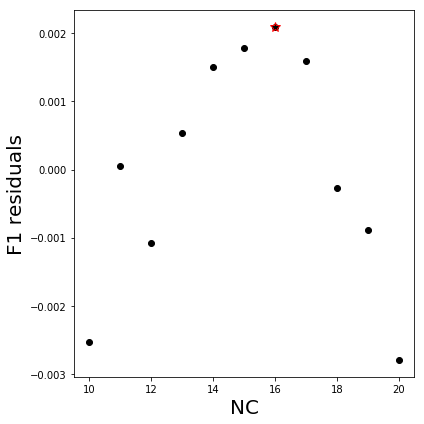

In [20]:
plt.clf()
plt.figure(figsize=(6,6))
plt.plot(NC_ar[cut], F1_ar733[cut] - y_fit[fitcut], 'ok')
plt.plot([best_NC],[best_residual], '*r', ms=10, fillstyle='none' )
#plt.plot(x_fit, y_fit, '--r')
plt.xlabel('NC', fontsize=20)
plt.ylabel('F1 residuals', fontsize=20)
plt.tight_layout()

plt.show()

In [21]:
best_index = np.argwhere(NC_ar[cut] == best_NC)[0][0]

In [22]:
best_index

6

<Figure size 432x288 with 0 Axes>

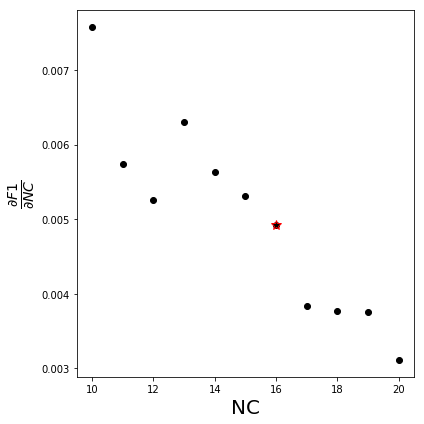

In [23]:
plt.clf()
plt.figure(figsize=(6,6))
plt.plot(NC_ar[cut], np.gradient(F1_ar733[cut], NC_ar[cut]), 'ok')
plt.plot([best_NC], np.gradient(F1_ar733[cut], NC_ar[cut])[best_index], '*r', ms=10, fillstyle='none' )

#plt.plot(x_fit, y_fit, '--r')
plt.xlabel('NC', fontsize=20)
plt.ylabel(r'$\frac{\partial F1}{\partial NC}$', fontsize=20)
plt.tight_layout()

plt.show()

In [24]:
prAUC_ar = np.array(prAUC_ar)

In [25]:
myslope = linregress(NC_ar[cut], prAUC_ar[cut])[0]
myintercept = linregress(NC_ar[cut], prAUC_ar[cut])[1]
x_fit = np.arange(9,22)
y_fit = x_fit*myslope + myintercept

In [26]:
fitcut = (x_fit>=10) * (x_fit<=20)

In [27]:
best_NC = 0
best_residual = -9999
for i in range(len(cut[cut])):
    residual =  prAUC_ar[cut][i] - y_fit[fitcut][i]
    print(NC_ar[cut][i], prAUC_ar[cut][i] - y_fit[fitcut][i])
    if residual > best_residual:
        best_residual = residual
        best_NC = NC_ar[cut][i]

10 -0.0027800647642090004
11 -0.001032762653697894
12 -0.0005475975864820404
13 0.0008979680003443624
14 0.001995952042028515
15 0.0021805759083443066
16 0.0022811312442280185
17 0.0015776232651731892
18 -0.0001650389341911751
19 -0.0012153924831224128
20 -0.0031923940384153138


<Figure size 432x288 with 0 Axes>

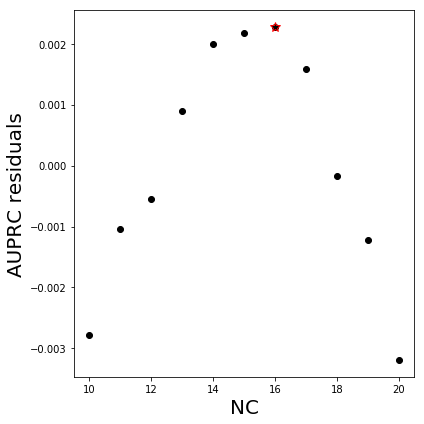

In [28]:
plt.clf()
plt.figure(figsize=(6,6))
plt.plot(NC_ar[cut], prAUC_ar[cut] - y_fit[fitcut], 'ok')
plt.plot([best_NC],[best_residual], '*r', ms=10, fillstyle='none' )
#plt.plot(x_fit, y_fit, '--r')
plt.xlabel('NC', fontsize=20)
plt.ylabel('AUPRC residuals', fontsize=20)
plt.tight_layout()

plt.show()

In [29]:
best_index = np.argwhere(NC_ar[cut] == best_NC)[0][0]

<Figure size 432x288 with 0 Axes>

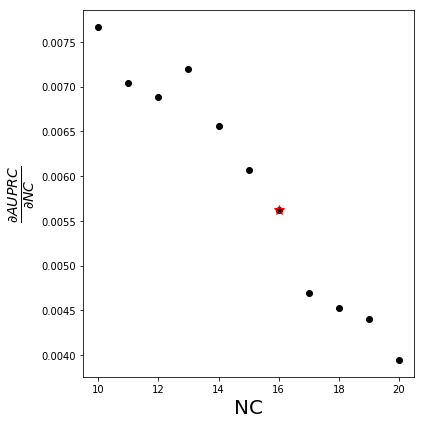

In [30]:
plt.clf()
plt.figure(figsize=(6,6))
plt.plot(NC_ar[cut], np.gradient(prAUC_ar[cut], NC_ar[cut]), 'ok')
plt.plot([best_NC], np.gradient(prAUC_ar[cut], NC_ar[cut])[best_index], '*r', ms=10, fillstyle='none' )

#plt.plot(x_fit, y_fit, '--r')
plt.xlabel('NC', fontsize=20)
plt.ylabel(r'$\frac{\partial AUPRC}{\partial NC}$', fontsize=20)
plt.tight_layout()

plt.show()

In [31]:
cut = (NC_ar>=4) * (NC_ar<=36)
myslope = linregress(NC_ar[cut], prAUC_ar[cut])[0]
myintercept = linregress(NC_ar[cut], prAUC_ar[cut])[1]
x_fit = np.arange(3,37)
y_fit = x_fit*myslope + myintercept
fitcut = (x_fit>=4) * (x_fit<=36)
best_NC = 0
best_residual = -9999
for i in range(len(cut[cut])):
    residual =  prAUC_ar[cut][i] - (NC_ar[cut][i]*myslope + myintercept)
    print(NC_ar[cut][i], prAUC_ar[cut][i] - (NC_ar[cut][i]*myslope + myintercept))
    if residual > best_residual:
        best_residual = residual
        best_NC = NC_ar[cut][i]
best_index = np.argwhere(NC_ar[cut] == best_NC)[0][0]


4 -0.042838268568757054
8 -0.007718025538862694
10 -0.0004700426357628906
11 0.0022860633369005123
12 0.0037800322662685515
13 0.006234401715247362
14 0.00834118961908381
15 0.0095346173475519
16 0.010643976545587908
17 0.010949272428685264
18 0.010215414091473196
19 0.010173864404694255
20 0.009205666711553762
24 0.004817455052394504
28 -0.0013610879983584345
32 -0.011951648743418808
36 -0.021842880034280476


In [32]:
best_NC

17

<Figure size 432x288 with 0 Axes>

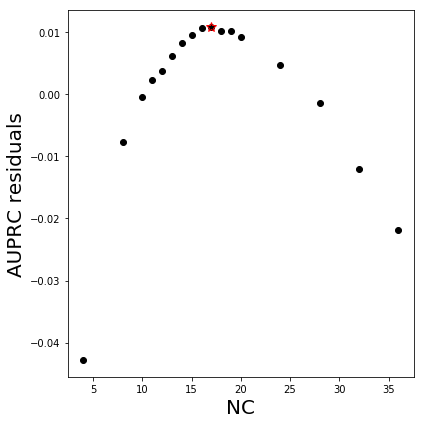

In [33]:
plt.clf()
plt.figure(figsize=(6,6))
plt.plot(NC_ar[cut], prAUC_ar[cut] -  (NC_ar[cut]*myslope + myintercept), 'ok')
plt.plot([best_NC],[best_residual], '*r', ms=10, fillstyle='none' )
#plt.plot(x_fit, y_fit, '--r')
plt.xlabel('NC', fontsize=20)
plt.ylabel('AUPRC residuals', fontsize=20)
plt.tight_layout()

plt.show()